## Discretized SARSA for mountain-car problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

### Step 2: Class Mountain car: 

Defines the environment consisting of a hill .Then provide bounds for the maximum and minimum velocity and position. Next, define the action space. 

Once the environment is setup, we will discretise the continuous state and compute the value for each state-action pair possible. Further, actions are taken according to the epsilon-greedy algorithm. 

In [2]:
class MountainCar(object):
    def __init__(self,alpha=0.3,gamma=1.0,epsilon=0.01):
        super(MountainCar, self).__init__()          
        self.alpha       = alpha    #learning rate
        self.gamma       = gamma    #discount factor
        self.epsilon     = epsilon  #probability of a random action selection
        self.statelist   = self.BuildSateList()     # the list of states
        self.actionlist  = self.BuildActionList()   # the list of actions        
        self.nactions    = self.actionlist.shape[0] # number of actions
        self.Q           = self.BuildQTable()       # the Qtable

    def BuildSateList(self):
        # state discretization for the mountain car problem
        xdiv  = (0.55-(-1.5))   / 10.0
        xpdiv = (0.07-(-0.07)) / 5.0
        
        x = np.arange(-1.5,0.5+xdiv,xdiv)
        xp= np.arange(-0.07,0.07+xpdiv,xpdiv)

        N=x.size
        M=xp.size

        states=[] #zeros((N*M,2)).astype(Float32)
        #index=0
        for i in range(N):    
            for j in range(M):
                states.append([x[i], xp[j]])        
        return np.array(states)

    def BuildActionList(self):
        return np.array([-1.0 , 0.0 , 1.0])

    def BuildQTable(self):
        nstates     = self.statelist.shape[0]
        nactions    = self.actionlist.shape[0]
        Q = [[0.0 for i in range(nactions)] for i in range(nstates)]
        return Q

    def GetReward(self, x ):
        # MountainCarGetReward returns the reward at the current state
        # x: a vector of position and velocity of the car
        # r: the returned reward.
        # f: true if the car reached the goal, otherwise f is false
            
        position = x[0]
        # bound for position; the goal is to reach position = 0.45
        bpright  = 0.45

        r = -1
        f = False
        
        
        if  position >= bpright:
            r = 100
            f = True
        
        return r,f

    
    def DoAction(self, force, x ):
        #MountainCarDoAction: executes the action (a) into the mountain car
        # a: is the force to be applied to the car
        # x: is the vector containning the position and speed of the car
        # xp: is the vector containing the new position and velocity of the car

        position = x[0]
        speed    = x[1] 

        # bounds for position
        bpleft=-1.5 

        # bounds for speed
        bsleft=-0.07 
        bsright=0.07
         
        speedt1= speed + (0.001*force) + (-0.0025 * math.cos( 3.0*position) )	 
        speedt1= speedt1 * 0.999 # thermodynamic law, for a more real system with friction.

        if speedt1<bsleft: 
            speedt1=bsleft 
        elif speedt1>bsright:
            speedt1=bsright    

        post1 = position + speedt1 

        if post1<=bpleft:
            post1=bpleft
            speedt1=0.0
            
        xp = np.array([post1,speedt1])
        return xp


    def GetInitialState(self):
        initial_position = -0.5
        initial_speed    =  0.0    
        return  np.array([initial_position,initial_speed])

    def DiscretizeState(self,x):    
        """DiscretizeState check which entry in the state list is more close to x and return the index of that entry."""
        
        edist2   = np.sqrt(np.sum((self.statelist-x)**2,1))
        return     np.argmin(edist2) 

    def e_greedy_selection(self, s):
        #selects an action using Epsilon-greedy strategy
        # Q: the Qtable
        # s: the current state        
                
        if (random.random()>self.epsilon):
            a = self.GetBestAction(s)    
        else:
            # selects a random action based on a uniform distribution
            a = random.randint(0, 2)
            #print(a)
        return a
        
    def GetBestAction(self, s ):
        #GetBestAction return the best action for state (s)
        #Q: the Qtable
        #the current state
        #has structure  Q(states,actions)
        
        #a = argmax(self.Q[s,:].flat)
        a  = np.argmax(self.Q[s])    
        return a

    def UpdateSARSA(self, s, a, r, sp, ap):
        """ Update Qtable using SARSA"""
        #print (s,sp, self.Q)
        self.Q[s][a]  = self.Q[s][a] + self.alpha * ( r + self.gamma*self.Q[sp][ap] - self.Q[s][a] )

    def SARSAEpisode(self, maxsteps=100, grafic = False):
        # do one episode with sarsa learning
        # maxstepts: the maximum number of steps per episode
        # Q: the current QTable
        # alpha: the current learning rate
        # gamma: the current discount factor
        # epsilon: probablity of a random action
        # statelist: the list of states
        # actionlist: the list of actions
        x_points = []
        y_points=[]
        x                = self.GetInitialState()
        steps            = 0
        total_reward     = 0
        x_points.append(x)

        # convert the continous state variables to an index of the statelist
        s   = self.DiscretizeState(x)
        
        # selects an action using the epsilon greedy selection strategy
        a   = self.e_greedy_selection(s)
        Cost = -np.max(self.Q[s])
        y_points.append(Cost)

        for i in range(1,maxsteps+1):
                        
            # convert the index of the action into an action value
            action = self.actionlist[a]    
            
            # do the selected action and get the next car state    
            xp     = self.DoAction( action , x )    
            
            # observe the reward at state xp and the final state flag
            r,isfinal    = self.GetReward(xp)
            total_reward = total_reward + r
            
            # convert the continous state variables in [xp] to an index of the statelist
            sp     = self.DiscretizeState(xp)
            
            # select action prime
            ap     = self.e_greedy_selection(sp)
            #print(ap)
            
            # Update the Qtable, that is,  learn from the experience
            self.UpdateSARSA( s, a, r, sp, ap)
            
            Cost = -np.max(self.Q[sp])
            y_points.append(Cost)
            x_points.append(xp)
            #update the current variables
            s = sp
            a = ap
            x = xp
            
            #if graphic function then show graphics
            if grafic:
                self.PlotFunc(x,a,steps)
                
            
            #increment the step counter.
            steps = steps+1
            
            # if reachs the goal breaks the episode
            if isfinal==True:
                break
        
        return total_reward,steps, x_points, y_points

### Step-3: 
Run the Code for 200 episodes. Each episode has maximum steps of 1000.

In [3]:
def MountainCarDemo(maxepisodes):
    MC  = MountainCar()
    maxsteps = 1000
    grafica  = False
    
    for i in range(1, maxepisodes+1):    
        X, Y =[], []
        total_reward,steps, x, Z  = MC.SARSAEpisode( maxsteps, grafica )    
        for j in range(len(x)):
            X.append(x[j][0]) 
            Y.append(x[j][1]) 
        
        if i==1000:
            fig = plt.figure()
            ax = fig.gca(projection='3d')          
            surf = ax.plot_trisurf(X, Y, Z, cmap=plt.cm.viridis, linewidth=0.2)
            fig.colorbar( surf, shrink=0.5, aspect=10)
            ax.set_xlabel("position")
            ax.set_ylabel("velocity")
            ax.set_zlabel("Cost function")
            plt.show()

        print ('Espisode: ',i,'  Steps:',steps,'  Reward:',str(total_reward),' epsilon: ',str(MC.epsilon))
        
        MC.epsilon = MC.epsilon * 0.99


Espisode:  1   Steps: 1000   Reward: -1000  epsilon:  0.01
Espisode:  2   Steps: 1000   Reward: -1000  epsilon:  0.0099
Espisode:  3   Steps: 1000   Reward: -1000  epsilon:  0.009801
Espisode:  4   Steps: 731   Reward: -630  epsilon:  0.00970299
Espisode:  5   Steps: 485   Reward: -384  epsilon:  0.0096059601
Espisode:  6   Steps: 743   Reward: -642  epsilon:  0.009509900499
Espisode:  7   Steps: 1000   Reward: -1000  epsilon:  0.00941480149401
Espisode:  8   Steps: 850   Reward: -749  epsilon:  0.0093206534790699
Espisode:  9   Steps: 701   Reward: -600  epsilon:  0.0092274469442792
Espisode:  10   Steps: 1000   Reward: -1000  epsilon:  0.009135172474836408
Espisode:  11   Steps: 1000   Reward: -1000  epsilon:  0.009043820750088045
Espisode:  12   Steps: 1000   Reward: -1000  epsilon:  0.008953382542587164
Espisode:  13   Steps: 476   Reward: -375  epsilon:  0.008863848717161293
Espisode:  14   Steps: 585   Reward: -484  epsilon:  0.00877521022998968
Espisode:  15   Steps: 1000   Rewa

Espisode:  121   Steps: 372   Reward: -271  epsilon:  0.002993803913123314
Espisode:  122   Steps: 468   Reward: -367  epsilon:  0.002963865873992081
Espisode:  123   Steps: 468   Reward: -367  epsilon:  0.00293422721525216
Espisode:  124   Steps: 468   Reward: -367  epsilon:  0.0029048849430996383
Espisode:  125   Steps: 471   Reward: -370  epsilon:  0.002875836093668642
Espisode:  126   Steps: 468   Reward: -367  epsilon:  0.0028470777327319553
Espisode:  127   Steps: 468   Reward: -367  epsilon:  0.0028186069554046356
Espisode:  128   Steps: 461   Reward: -360  epsilon:  0.002790420885850589
Espisode:  129   Steps: 468   Reward: -367  epsilon:  0.002762516676992083
Espisode:  130   Steps: 450   Reward: -349  epsilon:  0.0027348915102221624
Espisode:  131   Steps: 468   Reward: -367  epsilon:  0.0027075425951199406
Espisode:  132   Steps: 468   Reward: -367  epsilon:  0.0026804671691687413
Espisode:  133   Steps: 480   Reward: -379  epsilon:  0.0026536624974770537
Espisode:  134   St

Espisode:  231   Steps: 468   Reward: -367  epsilon:  0.000991048155188747
Espisode:  232   Steps: 468   Reward: -367  epsilon:  0.0009811376736368596
Espisode:  233   Steps: 468   Reward: -367  epsilon:  0.000971326296900491
Espisode:  234   Steps: 468   Reward: -367  epsilon:  0.000961613033931486
Espisode:  235   Steps: 468   Reward: -367  epsilon:  0.0009519969035921711
Espisode:  236   Steps: 468   Reward: -367  epsilon:  0.0009424769345562494
Espisode:  237   Steps: 468   Reward: -367  epsilon:  0.0009330521652106869
Espisode:  238   Steps: 468   Reward: -367  epsilon:  0.00092372164355858
Espisode:  239   Steps: 468   Reward: -367  epsilon:  0.0009144844271229942
Espisode:  240   Steps: 468   Reward: -367  epsilon:  0.0009053395828517643
Espisode:  241   Steps: 468   Reward: -367  epsilon:  0.0008962861870232467
Espisode:  242   Steps: 468   Reward: -367  epsilon:  0.0008873233251530142
Espisode:  243   Steps: 468   Reward: -367  epsilon:  0.0008784500919014841
Espisode:  244   

Espisode:  364   Steps: 468   Reward: -367  epsilon:  0.0002603608249392017
Espisode:  365   Steps: 468   Reward: -367  epsilon:  0.00025775721668980966
Espisode:  366   Steps: 468   Reward: -367  epsilon:  0.00025517964452291157
Espisode:  367   Steps: 468   Reward: -367  epsilon:  0.00025262784807768247
Espisode:  368   Steps: 468   Reward: -367  epsilon:  0.00025010156959690564
Espisode:  369   Steps: 468   Reward: -367  epsilon:  0.00024760055390093657
Espisode:  370   Steps: 468   Reward: -367  epsilon:  0.0002451245483619272
Espisode:  371   Steps: 468   Reward: -367  epsilon:  0.00024267330287830794
Espisode:  372   Steps: 468   Reward: -367  epsilon:  0.00024024656984952486
Espisode:  373   Steps: 468   Reward: -367  epsilon:  0.00023784410415102962
Espisode:  374   Steps: 468   Reward: -367  epsilon:  0.00023546566310951933
Espisode:  375   Steps: 468   Reward: -367  epsilon:  0.00023311100647842415
Espisode:  376   Steps: 468   Reward: -367  epsilon:  0.0002307798964136399
Es

Espisode:  473   Steps: 468   Reward: -367  epsilon:  8.70586343004352e-05
Espisode:  474   Steps: 468   Reward: -367  epsilon:  8.618804795743084e-05
Espisode:  475   Steps: 468   Reward: -367  epsilon:  8.532616747785654e-05
Espisode:  476   Steps: 468   Reward: -367  epsilon:  8.447290580307797e-05
Espisode:  477   Steps: 468   Reward: -367  epsilon:  8.362817674504719e-05
Espisode:  478   Steps: 468   Reward: -367  epsilon:  8.279189497759673e-05
Espisode:  479   Steps: 468   Reward: -367  epsilon:  8.196397602782075e-05
Espisode:  480   Steps: 468   Reward: -367  epsilon:  8.114433626754255e-05
Espisode:  481   Steps: 468   Reward: -367  epsilon:  8.033289290486713e-05
Espisode:  482   Steps: 468   Reward: -367  epsilon:  7.952956397581846e-05
Espisode:  483   Steps: 468   Reward: -367  epsilon:  7.873426833606028e-05
Espisode:  484   Steps: 468   Reward: -367  epsilon:  7.794692565269967e-05
Espisode:  485   Steps: 468   Reward: -367  epsilon:  7.716745639617267e-05
Espisode:  48

Espisode:  601   Steps: 468   Reward: -367  epsilon:  2.4050092913110723e-05
Espisode:  602   Steps: 468   Reward: -367  epsilon:  2.3809591983979617e-05
Espisode:  603   Steps: 468   Reward: -367  epsilon:  2.357149606413982e-05
Espisode:  604   Steps: 468   Reward: -367  epsilon:  2.3335781103498423e-05
Espisode:  605   Steps: 468   Reward: -367  epsilon:  2.3102423292463438e-05
Espisode:  606   Steps: 468   Reward: -367  epsilon:  2.2871399059538803e-05
Espisode:  607   Steps: 468   Reward: -367  epsilon:  2.2642685068943415e-05
Espisode:  608   Steps: 468   Reward: -367  epsilon:  2.241625821825398e-05
Espisode:  609   Steps: 468   Reward: -367  epsilon:  2.219209563607144e-05
Espisode:  610   Steps: 468   Reward: -367  epsilon:  2.1970174679710727e-05
Espisode:  611   Steps: 468   Reward: -367  epsilon:  2.175047293291362e-05
Espisode:  612   Steps: 468   Reward: -367  epsilon:  2.1532968203584482e-05
Espisode:  613   Steps: 468   Reward: -367  epsilon:  2.1317638521548636e-05
Esp

Espisode:  726   Steps: 468   Reward: -367  epsilon:  6.847248400305214e-06
Espisode:  727   Steps: 468   Reward: -367  epsilon:  6.778775916302162e-06
Espisode:  728   Steps: 468   Reward: -367  epsilon:  6.71098815713914e-06
Espisode:  729   Steps: 468   Reward: -367  epsilon:  6.6438782755677485e-06
Espisode:  730   Steps: 468   Reward: -367  epsilon:  6.577439492812071e-06
Espisode:  731   Steps: 468   Reward: -367  epsilon:  6.511665097883951e-06
Espisode:  732   Steps: 468   Reward: -367  epsilon:  6.446548446905111e-06
Espisode:  733   Steps: 468   Reward: -367  epsilon:  6.38208296243606e-06
Espisode:  734   Steps: 468   Reward: -367  epsilon:  6.318262132811699e-06
Espisode:  735   Steps: 468   Reward: -367  epsilon:  6.2550795114835825e-06
Espisode:  736   Steps: 468   Reward: -367  epsilon:  6.1925287163687465e-06
Espisode:  737   Steps: 468   Reward: -367  epsilon:  6.130603429205059e-06
Espisode:  738   Steps: 468   Reward: -367  epsilon:  6.0692973949130085e-06
Espisode: 

Espisode:  863   Steps: 468   Reward: -367  epsilon:  1.7279761466384874e-06
Espisode:  864   Steps: 468   Reward: -367  epsilon:  1.7106963851721026e-06
Espisode:  865   Steps: 468   Reward: -367  epsilon:  1.6935894213203816e-06
Espisode:  866   Steps: 468   Reward: -367  epsilon:  1.6766535271071777e-06
Espisode:  867   Steps: 468   Reward: -367  epsilon:  1.659886991836106e-06
Espisode:  868   Steps: 468   Reward: -367  epsilon:  1.6432881219177447e-06
Espisode:  869   Steps: 468   Reward: -367  epsilon:  1.6268552406985672e-06
Espisode:  870   Steps: 468   Reward: -367  epsilon:  1.6105866882915816e-06
Espisode:  871   Steps: 468   Reward: -367  epsilon:  1.5944808214086658e-06
Espisode:  872   Steps: 468   Reward: -367  epsilon:  1.578536013194579e-06
Espisode:  873   Steps: 468   Reward: -367  epsilon:  1.5627506530626331e-06
Espisode:  874   Steps: 468   Reward: -367  epsilon:  1.5471231465320069e-06
Espisode:  875   Steps: 468   Reward: -367  epsilon:  1.5316519150666867e-06
E

Espisode:  995   Steps: 468   Reward: -367  epsilon:  4.5854654968694606e-07
Espisode:  996   Steps: 468   Reward: -367  epsilon:  4.539610841900766e-07
Espisode:  997   Steps: 468   Reward: -367  epsilon:  4.4942147334817586e-07
Espisode:  998   Steps: 468   Reward: -367  epsilon:  4.449272586146941e-07
Espisode:  999   Steps: 468   Reward: -367  epsilon:  4.4047798602854717e-07


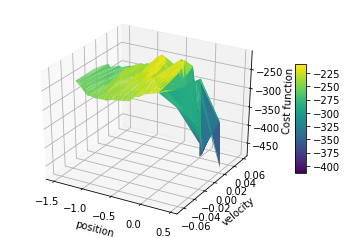

Espisode:  1000   Steps: 468   Reward: -367  epsilon:  4.360732061682617e-07


In [4]:
if __name__ == '__main__':
    MountainCarDemo(1000) 